### Constructing the Molecule

In [120]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="He 0 0 0; H+ 0 0 0.772",
    basis="sto-3g",
    charge=1,
    spin=0,
    
)

problem = driver.run()
print(problem)

### Converting to fermionic operator

In [121]:
fermionic_op = problem.hamiltonian.second_q_op()
#print(fermionic_op)

### Jordan-Wigner Mapping 

In [122]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(fermionic_op)
#print(qubit_jw_op)

### Constructing the Optimization Log

In [123]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

### Chosing the Optimization Method and Variational Form

In [124]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP,SPSA,COBYLA, L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
import numpy as np
#this is the optimization method
log = OptimizerLog() 

Optimizer = SLSQP()
# Sequential Least Squares Programming
Optimizer2 = SPSA()
#Simultanious Pertubation Stochastic Approximation
'''
The main feature of SPSA is the stochastic gradient approximation, 
which requires only two measurements of the objective function, regardless of the dimension of the optimization problem.
'''
Optimizer3 = COBYLA()

Optimizer4 = L_BFGS_B()

# Using Unitary Coupled Cluster as Variational Form and HatreeFock for intial states
 
# The Variation Form does affect the number parameters(theta) which also impact the number 
# of iteration and expectation value (ground-state energy)

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)

#Set the initial parameters(theta) as random - this will 
# also affect the convergence of the plot and number of iteration.

#maybe we can a away to appoximate the intial points
vqe_solver.initial_point = np.random.random(ansatz.num_parameters)

#ansatz.decompose().decompose().draw('mpl')

/tmp/ipykernel_7640/3046545942.py:37: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, optimizer=Optimizer,callback=log.update)


### Solving the Ground-state energy

In [125]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_aer import AerSimulator, Aer
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.221949436267
  - computed part:      -4.221949436267
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -2.851024019376
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.386320566725]
    - computed part:      [0.0  0.0  0.386320566725]
  > Dipole moment (a.u.): [0.0  0.0  1.072548003275]  Total: 1.072548003275
                 (debye): [0.0  0.0  2.726144844949]  Total: 2.726144844949
 


### Ploting the Optimization value over iteration

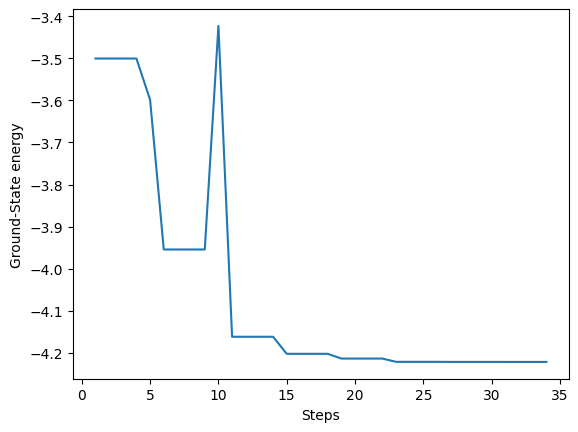

In [126]:
import matplotlib.pyplot as plt

figfig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

### Ploting the Paramaters(theta) over iteration

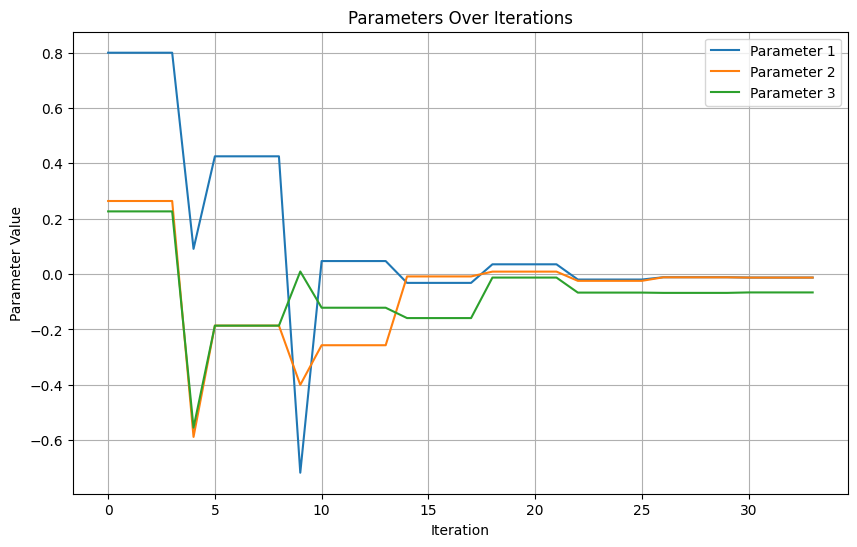

In [127]:
# Extract parameters
data = log.parameters
iterations = range(len(data))
param1 = [row[0] for row in data]
param2 = [row[1] for row in data]
param3 = [row[2] for row in data]

# Plotting the parameters
plt.figure(figsize=(10, 6))

plt.plot(iterations, param1, label='Parameter 1')
plt.plot(iterations, param2, label='Parameter 2')
plt.plot(iterations, param3, label='Parameter 3')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

### A Different Variational Method.

In [128]:
log2 = OptimizerLog()

In [129]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
import numpy as np
# Initial States base on HatreeFock approximation 
reference_circuit = QuantumCircuit(4)
reference_circuit.x(0)
reference_circuit.x(2)
ansatz2 = TwoLocal(
    4,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz2 = reference_circuit.compose(ansatz2)
vqe_solver2 = VQE(Estimator(), ansatz2, optimizer=Optimizer,callback=log2.update)
vqe_solver2.initial_point= np.random.random(ansatz2.num_parameters)

from qiskit_nature.second_q.algorithms import GroundStateEigensolver
#from qiskit_aer import AerSimulator, Aer
calc2 = GroundStateEigensolver(mapper, vqe_solver2)
res2 = calc2.solve(problem)
print(res2)

/tmp/ipykernel_7640/2111297350.py:16: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver2 = VQE(Estimator(), ansatz2, optimizer=Optimizer,callback=log2.update)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -4.383100342663
  - computed part:      -4.383100342663
~ Nuclear repulsion energy (Hartree): 1.370925416891
> Total ground state energy (Hartree): -3.012174925772
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.500
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.45886857]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.743455202196]
    - computed part:      [0.0  0.0  1.743455202196]
  > Dipole moment (a.u.): [0.0  0.0  -0.284586632196]  Total: 0.284586632196
                 (debye): [0.0  0.0  -0.723346999792]  Total: 0.723346999792
 


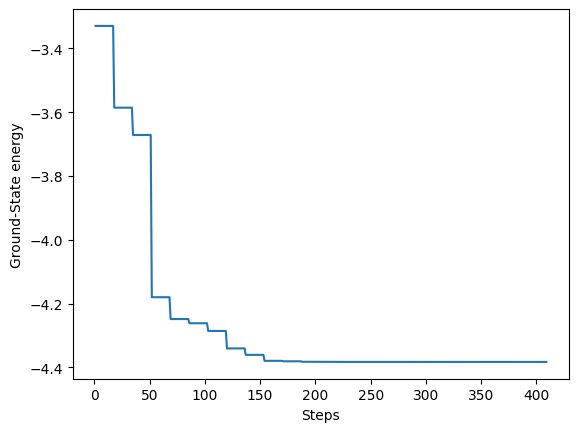

In [130]:
import matplotlib.pyplot as plt

figfig = plt.figure()
plt.plot(log2.evaluations, log2.costs)
plt.xlabel('Steps')
plt.ylabel('Ground-State energy')
plt.show()

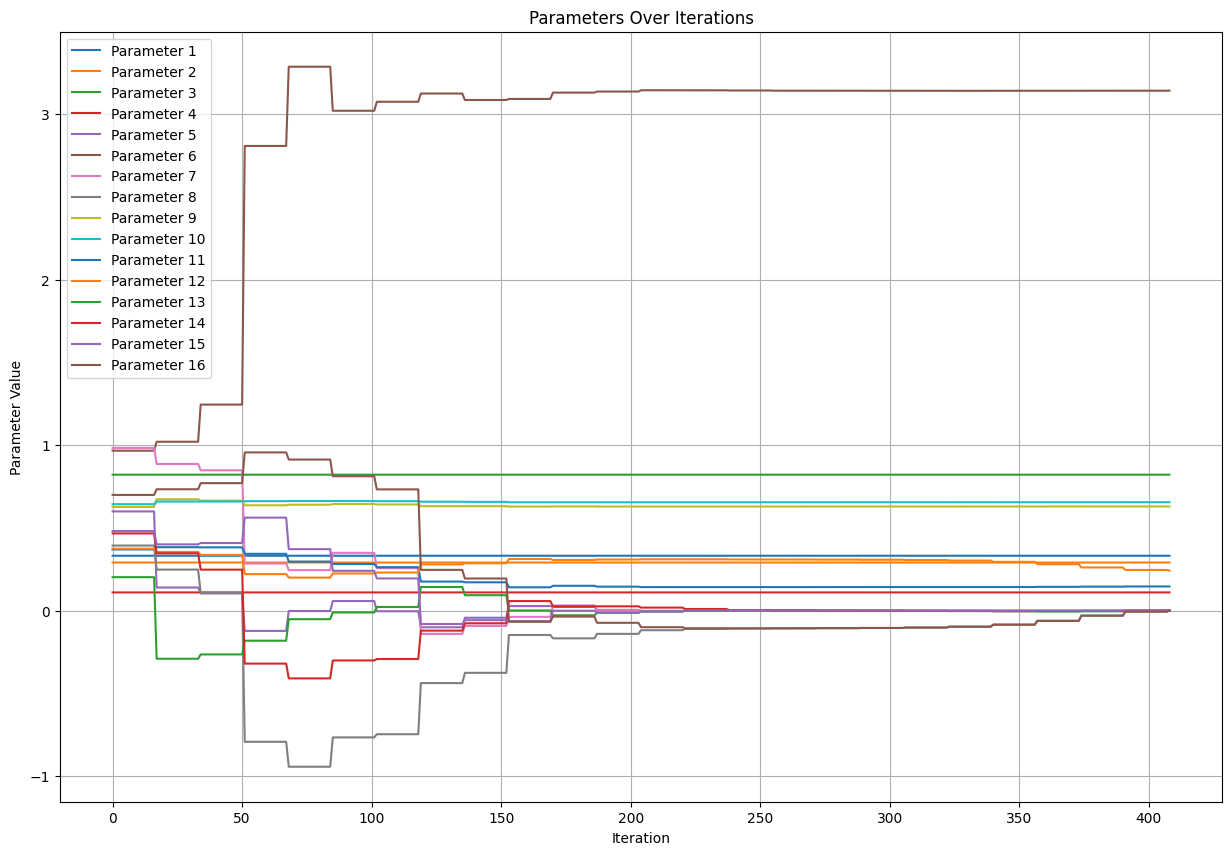

In [134]:
# Extract parameters
data2 = log2.parameters
iterations = range(len(data2))

# Extract all 16 parameters
parameters = [[row[i] for row in data2] for i in range(16)]

# Plotting the parameters
plt.figure(figsize=(15, 10))

# Plot each parameter
for i in range(16):
    plt.plot(iterations, parameters[i], label=f'Parameter {i+1}')

plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameters Over Iterations')
plt.legend()
plt.grid(True)
plt.show()